# Trabalho Final - NLP
Link da apresentação: https://youtu.be/hoM-RYMYmYQ

Trabalho final para a disciplina de Machine Learning para NLP, do curso de Ciência da computação da UFMG. Para o trabalho foi escolhida a base de dados Brazilian E-Commerce Public Dataset by Olist, disponibilizado na Kaggle(https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

In [16]:
pip install keras-tuner

### Importando módulos

In [17]:
from argparse import Namespace

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [59]:
args = Namespace(
    dataset_csv = './olist_order_reviews_dataset.csv',
    train_split = 0.8,
    random_state = 26,
    vocab_size = 10000,
    embedding_dim = 20,
    max_length = 120,
    batch_size= 64,
    num_epochs= 5,
    early_stopping_criteria= 2,
    dropout_p= 0.3,
    model_storage="model_storage/lstm",
)

### Funções auxiliares


In [30]:
def load_data(path, column_text='review_comment_message', column_score='review_score', points_cut = [0, 3, 5], classes = [0, 1]):
    """
    Args
        path - Dataframe
        column_text - Column text
        column_score - Random State
        points_cut - Cut points in score
        classes - Classes
    Return
        df - Dataframe loaded
    """
    df = pd.read_csv(path)
    df = df.dropna(subset=[column_text])

    df['label'] = pd.cut(df[column_score], bins=points_cut, labels=classes)

    df = df.rename(columns={column_text: 'text'})
    df = df[['text','label']]

    return df

In [32]:
df = load_data('/olist_order_reviews_dataset.csv')
df

,text,label
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1
...,...,...
99205,para este produto recebi de acordo com a compr...,1
99208,Entregou dentro do prazo. O produto chegou em ...,1
99215,"O produto não foi enviado com NF, não existe v...",0
99221,"Excelente mochila, entrega super rápida. Super...",1


Após tratar os dados, restam cera de 41.000 comentários a ser usados. Divisão de treino/validação/teste será 7:1:2.

In [33]:
import numpy as np

def split_test_train(data, split_train=0.8, random_state=200):
    """
    Args
        df - Dataframe
        split_train - Percent of subset train
        random_state - Random State
    Return
        training_sentence - training subset with text
        training_label - training subset with label
        test_sentence - test subset with text
        test_label - test subset with label
    """
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    training_sentences = []
    training_labels = []
    testing_sentences = []
    testing_labels = []
    for index, train in df_train.iterrows():
        training_sentences.append(str(train['text']))
        training_labels.append(train['label'])

    for index, test in df_test.iterrows():
        testing_sentences.append(str(test['text']))
        testing_labels.append(test['label'])

    return training_sentences, training_labels, testing_sentences, testing_labels

In [34]:
training_sentences, training_labels, test_sentences, test_labels = split_test_train(df, split_train=args.train_split, random_state=args.random_state)

### Pré-processamento

In [35]:
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = args.vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

def preprocess(training_sentences, testing_sentences, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):
    """
    Args
        training_sentences
        training_labels
        testing_sentences
        testing_labels
    Return
        training_sentences
        training_labels
        testing_sentences
        testing_labels
    """
    training_sentences = tokenizer.texts_to_sequences(training_sentences)
    training_padded = pad_sequences(training_sentences,maxlen=max_length, truncating=trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
    testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
    return training_padded, testing_padded

In [39]:
training_sentences, test_sentences = preprocess(training_sentences, test_sentences, args.max_length, args.vocab_size)

### Modelo

In [36]:
import keras_tuner
import keras
import tensorflow as tf
from kerastuner import HyperParameters


def create_model(hp):
    max_length = args.max_length
    vocab_size = args.vocab_size

    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=128, step=32)
    lstm_units = hp.Int('lstm_units', min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)

    input = tf.keras.Input(shape=(max_length,))
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(input)

    x = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units)(x)

    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Dense(32, activation='relu')(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(input, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

tuner = keras_tuner.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=30,
    directory='my_dir',
    project_name='lstm_tuning'
)



<ipython-input-36-c7d9b9fe77ba>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


### Separando os dados de treino e validação

In [41]:
x_val = training_sentences[:4100].copy()
x_train = training_sentences[4100:].copy()
y_val = training_labels[:4100].copy()
y_train = training_labels[4100:].copy()
y_train = np.array(y_train)
y_val = np.array(y_val)

In [42]:
tuner.search(x_train, y_train, epochs=30, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Trial 82 Complete [00h 01m 11s]
val_accuracy: 0.9004877805709839

Best val_accuracy So Far: 0.9048780202865601
Total elapsed time: 01h 09m 37s


### Melhores dez modelos testados pelo tuner

In [49]:
tuner.results_summary()

Results summary
Results in my_dir/lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0079 summary
Hyperparameters:
embedding_dim: 96
lstm_units: 64
dropout_rate: 0.4
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9048780202865601

Trial 0023 summary
Hyperparameters:
embedding_dim: 96
lstm_units: 64
dropout_rate: 0.5
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9036585092544556

Trial 0029 summary
Hyperparameters:
embedding_dim: 32
lstm_units: 48
dropout_rate: 0.5
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9036585092544556

Trial 0043 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 48
dropout_rate: 0.5
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0016
Score: 0.9036585092544556

Trial 0049 summary
Hyperparameters:
embedding_dim: 64
lstm_units: 48
dropout_rate: 0.4
tuner/epochs: 4
tuner/initial_ep

### Obtendo o melhor modelo

In [51]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [47]:
model = tuner.hypermodel.build(best_hps)

In [50]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=args.early_stopping_criteria)

history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))


Epoch 1/30
897/897 [==============================] - 12s 13ms/step - loss: 0.1967 - accuracy: 0.9335 - val_loss: 0.2795 - val_accuracy: 0.8976
Epoch 2/30
897/897 [==============================] - 11s 12ms/step - loss: 0.1658 - accuracy: 0.9442 - val_loss: 0.3217 - val_accuracy: 0.8910
Epoch 3/30
897/897 [==============================] - 11s 12ms/step - loss: 0.1445 - accuracy: 0.9531 - val_loss: 0.3722 - val_accuracy: 0.8868
Epoch 4/30
897/897 [==============================] - 11s 12ms/step - loss: 0.1258 - accuracy: 0.9603 - val_loss: 0.3668 - val_accuracy: 0.8807
Epoch 5/30
897/897 [==============================] - 11s 12ms/step - loss: 0.1127 - accuracy: 0.9650 - val_loss: 0.4297 - val_accuracy: 0.8812
Epoch 6/30
897/897 [==============================] - 10s 12ms/step - loss: 0.1052 - accuracy: 0.9679 - val_loss: 0.4487 - val_accuracy: 0.8829
Epoch 7/30
897/897 [==============================] - 11s 12ms/step - loss: 0.0979 - accuracy: 0.9696 - val_loss: 0.4591 - val_accuracy:

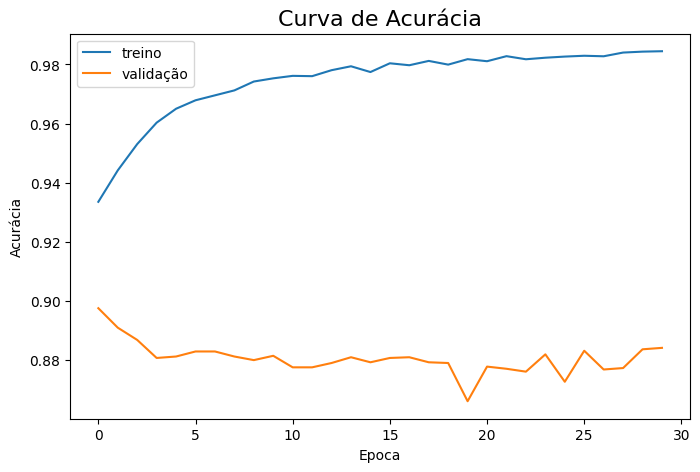

In [53]:
plt.figure(figsize = (8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Acurácia', fontsize = 16)
plt.ylabel('Acurácia')
plt.xlabel('Epoca')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

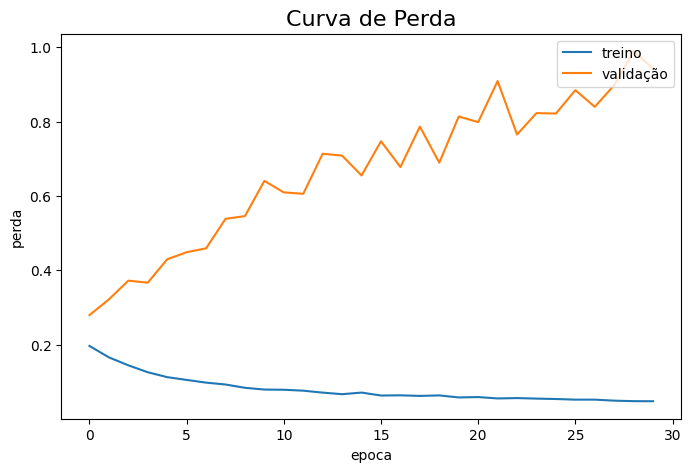

In [54]:
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Curva de Perda', fontsize = 16)
plt.ylabel('perda')
plt.xlabel('epoca')
plt.legend(['treino', 'validação'], loc='upper right')
plt.show()

### Testando o modelo

In [55]:
y_predicted_prob = model.predict(test_sentences, verbose=1)
y_predicted_classes = np.where(y_predicted_prob > 0.5, 1, 0)

y_predicted_prob = y_predicted_prob[:, 0]
y_predicted_classes = y_predicted_classes[:, 0]

257/257 [==============================] - 2s 4ms/step


In [56]:
accuracy = accuracy_score(test_labels, y_predicted_classes)
print('Accuracy: %f' % accuracy)

precision = precision_score(test_labels, y_predicted_classes)
print('Precision: %f' % precision)

recall = recall_score(test_labels, y_predicted_classes)
print('Recall: %f' % recall)

f1 = f1_score(test_labels, y_predicted_classes)
print('F1 score: %f' % f1)

Accuracy: 0.874436
Precision: 0.900546
Recall: 0.905150
F1 score: 0.902842


### Matriz de confusão

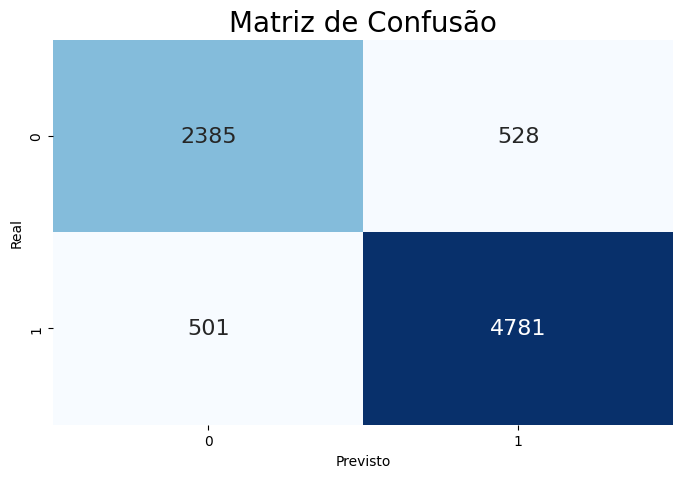

In [58]:
data = confusion_matrix(test_labels, y_predicted_classes)
df_cm = pd.DataFrame(data, columns=np.unique(y_predicted_classes), index = np.unique(y_predicted_classes))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Previsto'
plt.figure(figsize = (8,5))
plt.title('Matriz de Confusão', fontsize = 20)

sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### ROC

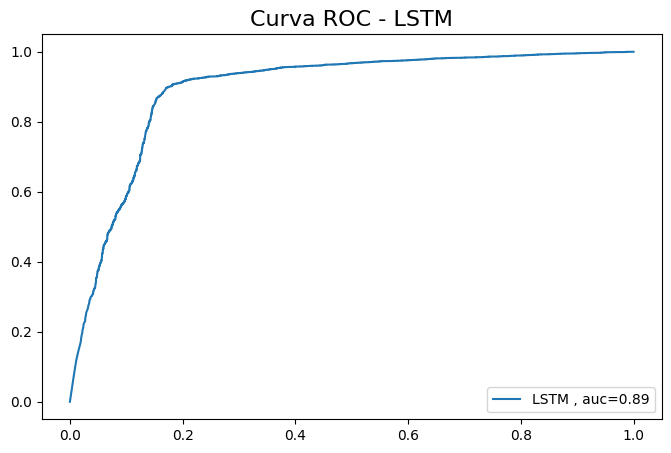

In [57]:
fpr, tpr, _ = roc_curve(test_labels, y_predicted_prob)
auc = roc_auc_score(test_labels, y_predicted_prob)
plt.figure(figsize = (8,5))

plt.plot(fpr,tpr,label="LSTM , auc="+str(round(auc,2)))
plt.title('Curva ROC - LSTM', fontsize = 16)
plt.legend(loc=4)
plt.show()